In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST data
train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##Two layer model architecture as defined in paper 

In [2]:
# Model architecture
class TwoLayerNet(nn.Module):
    def __init__(self, hidden_width):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(784, hidden_width)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_width, 10) 

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
lr = 0.5
weight_decay = 0
momentum = 0.9
nesterov = True
sigma = 0.1  
d_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

##Note: In both the scenarios, with constant and varying learning rates, there is a noise added as mentioned in paper. 

##Varying learning rate

##With λ = 0.5/d

In [4]:
variance_values_varying_learning_rate = []
for d in d_values:
    model = TwoLayerNet(d).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr/d,weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    loss_values = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        noise = torch.randn_like(target.float()) * sigma
        noisy_target = torch.clamp((target + noise).long(), 0, 9)
        loss = loss_fn(output, noisy_target)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    
    variance = torch.var(torch.tensor(loss_values))
    variance_values_varying_learning_rate.append(variance.item())

##Constant learning rate

##With λ = 0.5


In [6]:
variance_values_constant_learning_rate = []
for d in d_values:
    model = TwoLayerNet(d).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    loss_values = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        noise = torch.randn_like(target.float()) * sigma
        noisy_target = torch.clamp((target + noise).long(), 0, 9) 
        loss = loss_fn(output, noisy_target)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    
    variance = torch.var(torch.tensor(loss_values))
    variance_values_constant_learning_rate.append(variance.item())

##Results
This is to depict results from paper that variance explodes after d ≥ 200. In contrast, rescaling the learning rate by 1/d results in a constant noise level in training

Note: Results are not exactly matching as in paper 
Few things still to try
1. Use diffrent batch sizes 
2. Using different weight decay values 

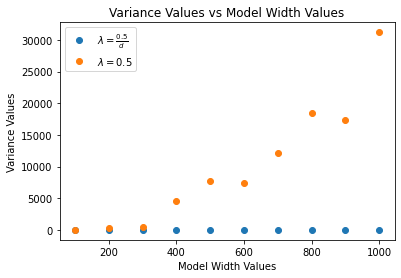

In [10]:
import matplotlib.pyplot as plt

model_width_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# plot the data
plt.plot(model_width_values, variance_values_varying_learning_rate,'o', label=r'$\lambda = \frac{0.5}{d}$')
plt.plot(model_width_values, variance_values_constant_learning_rate, 'o', label=r'$\lambda = 0.5$')
plt.legend()
plt.xlabel('Model Width Values')
plt.ylabel('Variance Values')
plt.title('Variance Values vs Model Width Values')
plt.show()